# Research

In [1]:
import pandas as pd
import sklearn 
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
plt.style.use('ggplot')

## load data

In [3]:
# Connect to your postgres DB
conn = psycopg2.connect(
    dbname="dsp",
    user="dsp",
    password="dsp",
    host="localhost",
    port="5432")

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
cur.execute("SELECT * FROM ctr")

# Retrieve query results
records = cur.fetchall()

In [4]:
ctr_data = pd.DataFrame(
    records, 
    columns=[
        "ad_id",
        "status",
        "bidding_cpc",
        "advertiser",
        "banner_style",
        "category",
        "height",
        "width",
        "item_price",
        "layout_style",
        "hist_ctr",
        "hist_cvr",
        "was_click"
    ]
)

In [5]:
ctr_data.head()

,ad_id,status,bidding_cpc,advertiser,banner_style,category,height,width,item_price,layout_style,hist_ctr,hist_cvr,was_click
0,1228,False,1.0,QQ,VII,Pullover,27.341918,617.516273,2896.437068,MP,0.000366,0.000068,False
1,1792,False,1.0,AAT,X,Trouser,92.063239,214.452624,2090.988338,CP,0.000617,0.000140,False
2,1072,True,1.0,WKN,VII,Bag,53.559076,632.539902,1267.726492,HU,0.043057,0.000114,False
3,351,True,2.0,DQT,XV,Coat,15.722390,707.972269,625.479827,BE,0.001542,0.000020,False
4,1764,True,2.0,WCI,IX,Trouser,6.916314,393.056523,2707.362702,TX,0.014159,0.000194,False


In [6]:
np.mean(ctr_data["hist_ctr"])

0.009905203839797677

## choice top 10 feature from correlation

In [7]:
numerical_features = ["bidding_cpc", "height", "width", "item_price", "hist_ctr", "hist_cvr"]
categorical_features = ["banner_style", "category", "layout_style"]
target_features = ["was_click"]

In [8]:
formated_data = pd.concat(
    [
        pd.get_dummies(ctr_data[categorical_features]), 
        ctr_data[numerical_features],
        ctr_data[target_features]
    ],  axis=1)

In [9]:
correlation_matrix = formated_data.corr()

In [10]:
correlation_matrix["was_click_abs"] = abs(correlation_matrix["was_click"])

In [11]:
correlation_matrix["was_click_abs"].sort_values(ascending=False).head(11)

was_click          1.000000
layout_style_AB    0.010976
layout_style_RU    0.005915
layout_style_GY    0.005826
layout_style_MR    0.005815
layout_style_BK    0.005572
layout_style_BX    0.005548
layout_style_RZ    0.005274
layout_style_TY    0.005184
category_Shirt     0.005042
layout_style_DX    0.004874
Name: was_click_abs, dtype: float64

In [12]:
decided_features = list(correlation_matrix["was_click_abs"].sort_values(ascending=False).head(11).index)[1:]
print(decided_features)

['layout_style_AB', 'layout_style_RU', 'layout_style_GY', 'layout_style_MR', 'layout_style_BK', 'layout_style_BX', 'layout_style_RZ', 'layout_style_TY', 'category_Shirt', 'layout_style_DX']


## fit model

In [13]:
X, y = formated_data[decided_features], formated_data["was_click"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [14]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

## check result

In [15]:
clf.score(X_test, y_test)

0.9986666666666667

In [16]:
predictions = clf.predict_proba(X_test)[:,1]

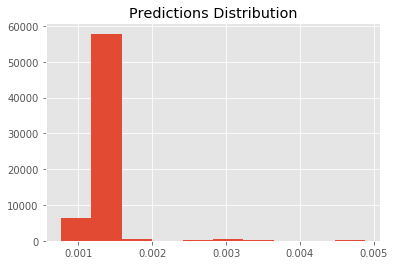

In [17]:
# Predictions histogram
plt.title("Predictions Distribution")
plt.hist(predictions)
plt.show()

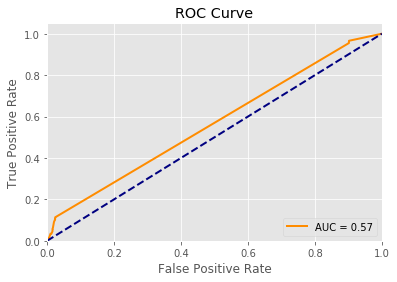

In [18]:
# Roc curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

LogisticRegression model: auc=0.009


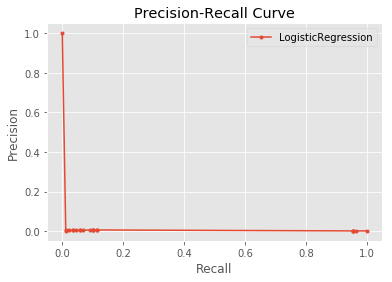

In [19]:
# Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

model_auc = auc(recall, precision)

# summarize scores
print('LogisticRegression model: auc=%.3f' % (model_auc))

# plot the precision-recall curves
plt.plot(recall, precision, marker='.', label="LogisticRegression")
# axis labels
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

 ## Reference
- [Precision Recall Curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)